In [4]:
import os
print(os.environ["PYTHONPATH"])  # Should contain parent dirrectory of image_captioning module

/home/k/retail


In [5]:
import json

import pandas as pd
import numpy as np
import editdistance
import matplotlib.pyplot  as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

import torch

import image_captioning.constants as C
from image_captioning.caption import caption_image_beam_search, visualize_att

In [6]:
report = pd.read_csv(str(C.SVHN_EVAL_PATH), dtype=np.object)
report["score"] = report["score"].astype(np.float)
report["probability"]= np.exp(report["score"])
report["predicted"] = report["predicted"].fillna("")
report["edit_distance"] = report.apply(lambda x: editdistance.eval(x["predicted"], x["correct"]), axis=1)
report["norm_edit_distance"] = report.apply(lambda x: x["edit_distance"] / len(x["correct"]), axis=1)
report["delusion"] = report["edit_distance"] * report["probability"] 
report["error"] = report["predicted"] != report["correct"]
report = report.sort_values(by="delusion", ascending=False)
report.head()

path predicted correct     score  \
1849  /home/k/retail/data/svhn/test/12067.png         2     141 -0.002076   
2035    /home/k/retail/data/svhn/test/836.png       567     301 -0.054663   
6425   /home/k/retail/data/svhn/test/7278.png      1324    1502 -0.070357   
8991   /home/k/retail/data/svhn/test/8639.png        99     303 -0.074111   
6982   /home/k/retail/data/svhn/test/3580.png       451      86 -0.161927   

      probability  edit_distance  norm_edit_distance  delusion  error  
1849     0.997926              3                1.00  2.993778   True  
2035     0.946804              3                1.00  2.840413   True  
6425     0.932061              3                0.75  2.796183   True  
8991     0.928569              3                1.00  2.785706   True  
6982     0.850503              3                1.50  2.551510   True

In [7]:
report[["error", "norm_edit_distance", "edit_distance"]].mean().to_frame().T

error  norm_edit_distance  edit_distance
0  0.345041            0.269345       0.506657

In [8]:
SHOW = 30
class args:
    model = "BEST_checkpoint_svhn_1_cap_per_img_5_min_word_freq.pth.tar"
    word_map = str(C.DIGIT_WORD_MAP_PATH)
    beam_size = 3
    smooth = True
    
device = "cpu"

# Load model
checkpoint = torch.load(args.model)
decoder = checkpoint['decoder'].to(device)
decoder.eval()
encoder = checkpoint['encoder'].to(device)
encoder.eval()

# Load word map (word2ix)
with open(args.word_map, 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


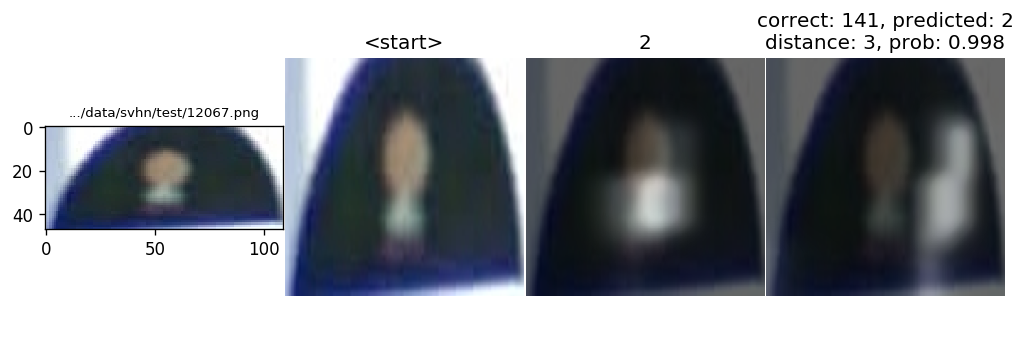

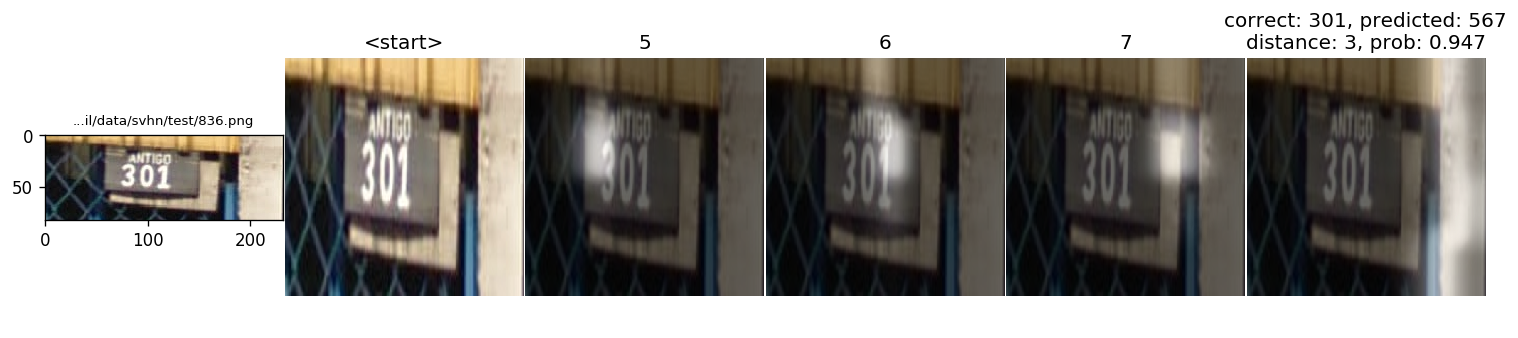

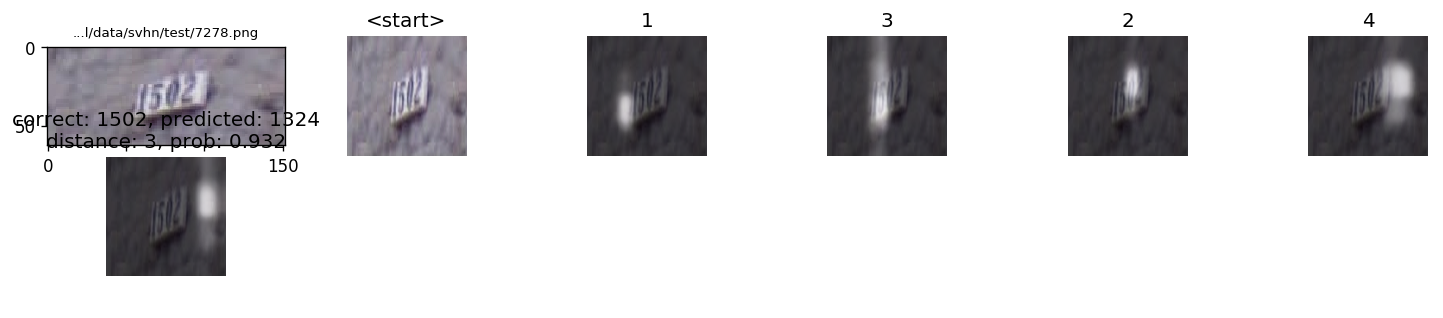

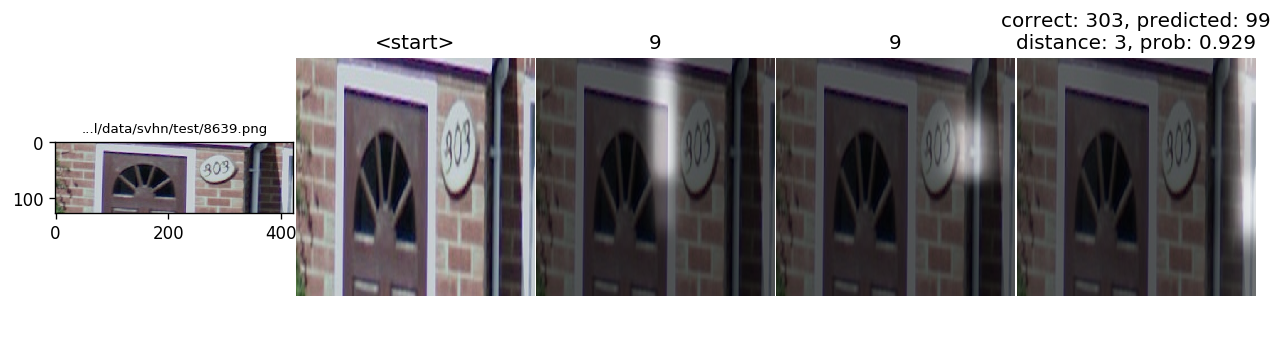

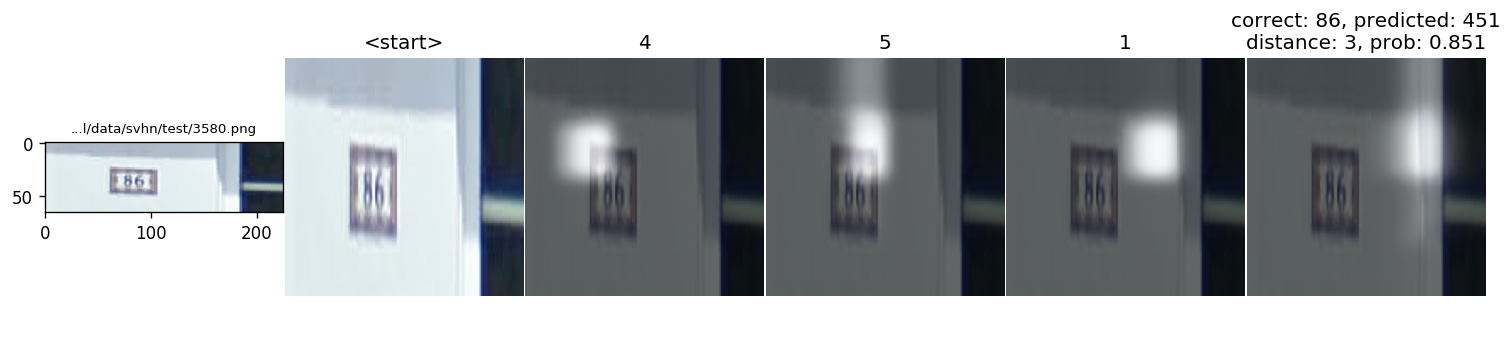

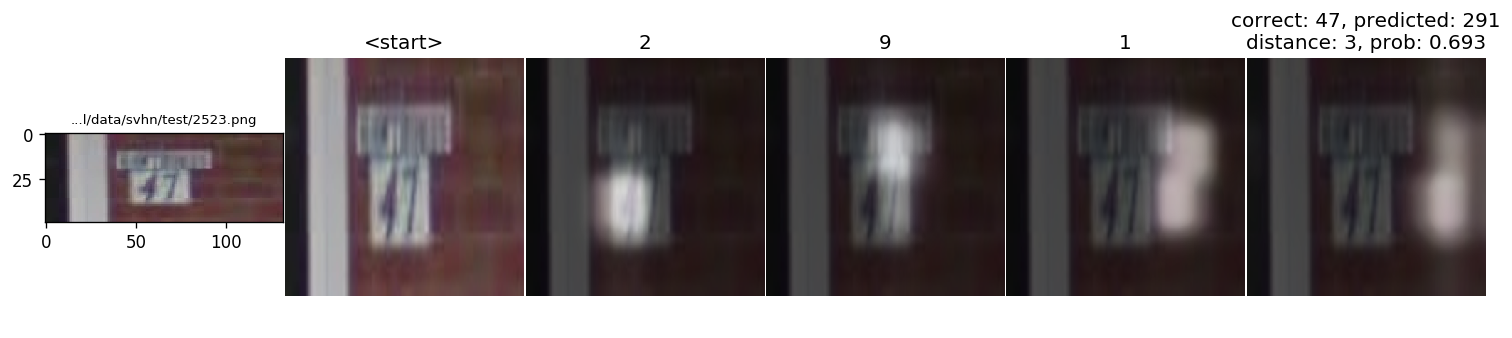

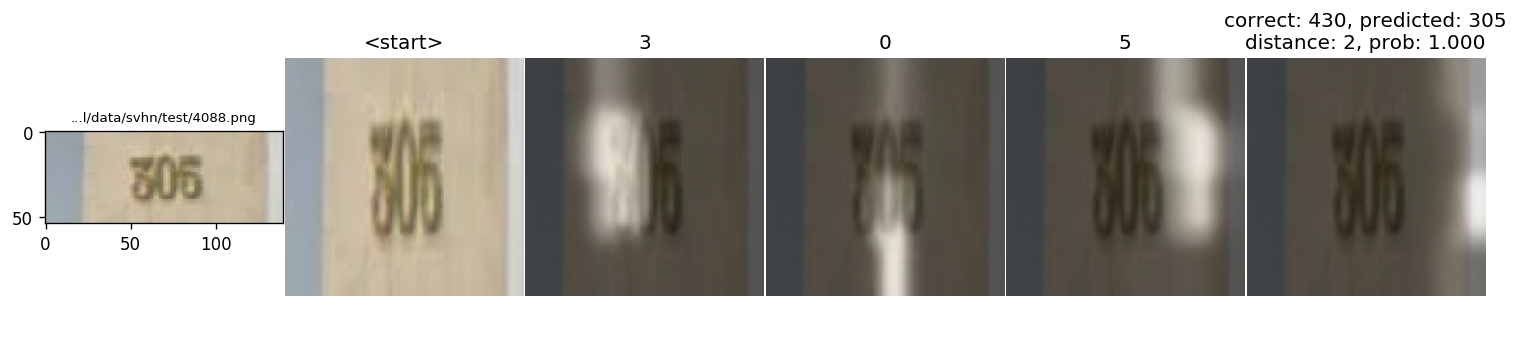

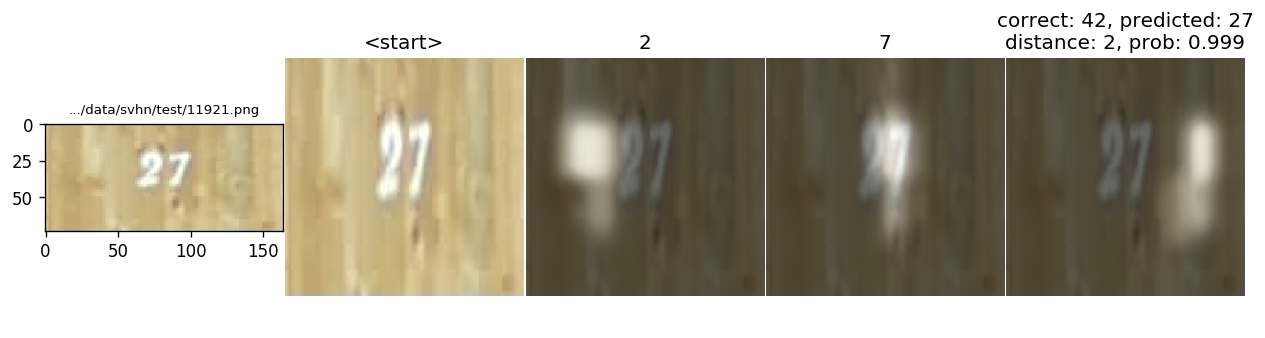

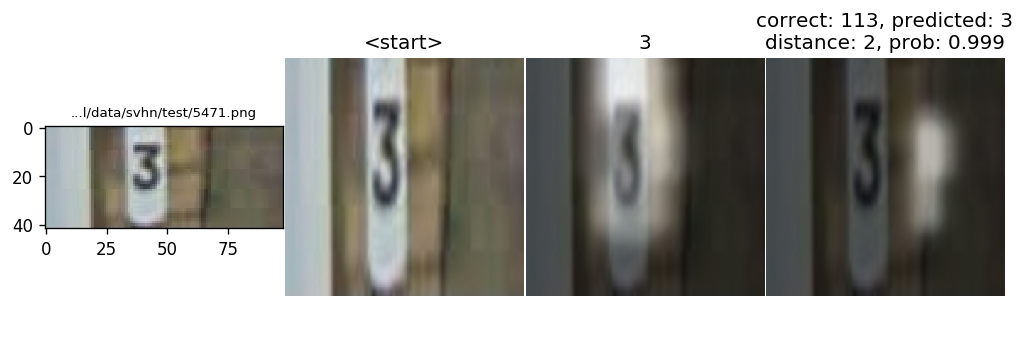

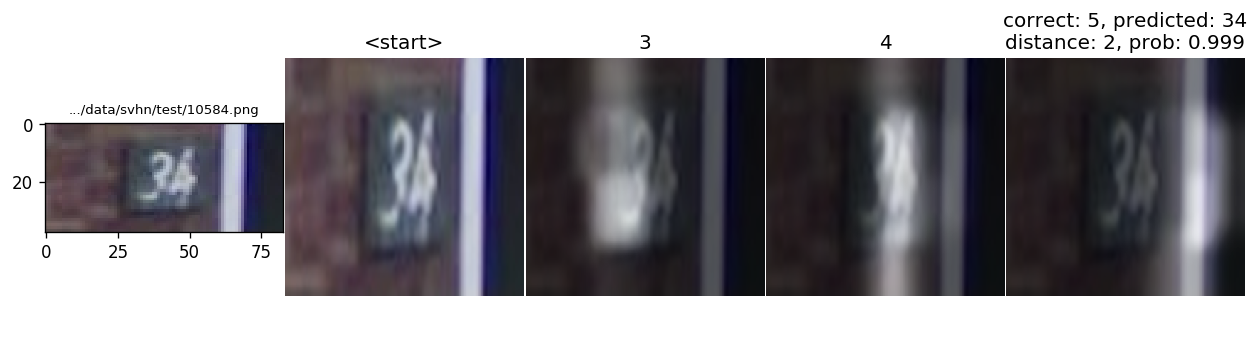

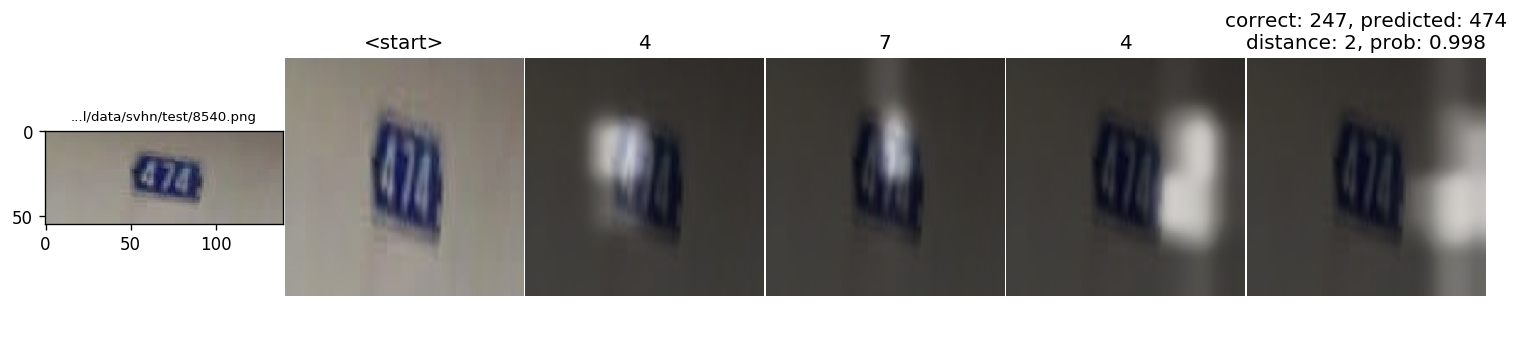

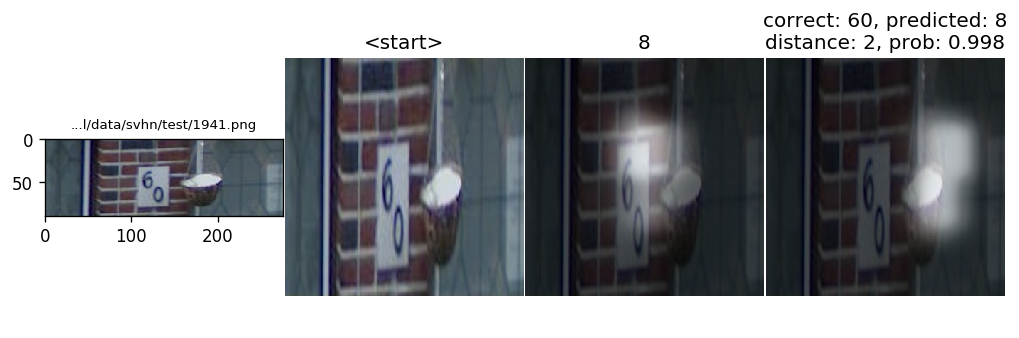

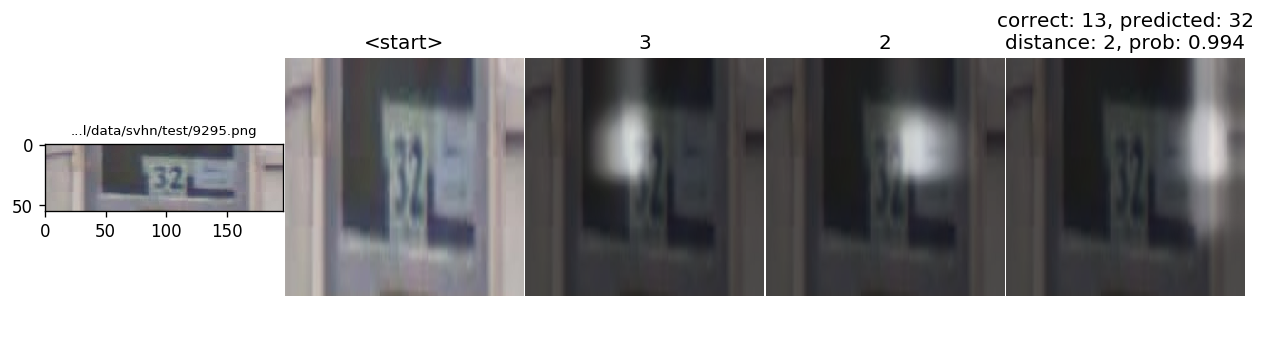

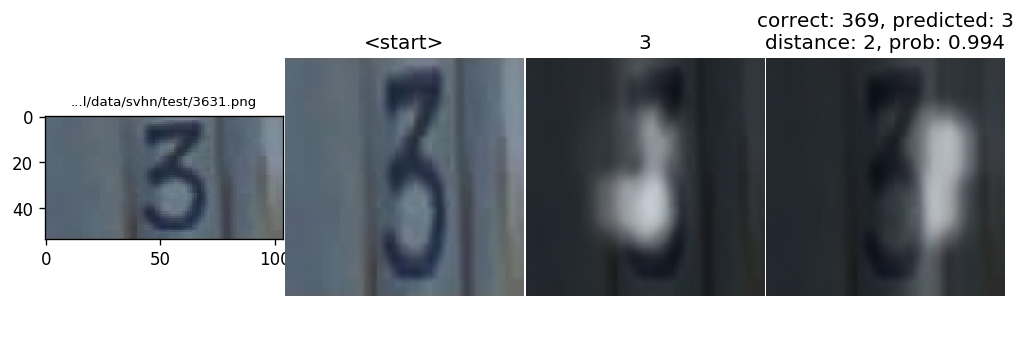

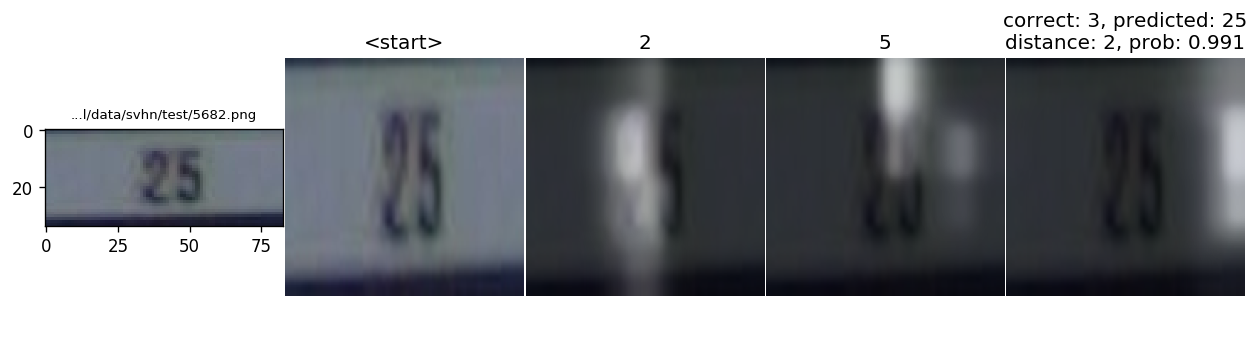

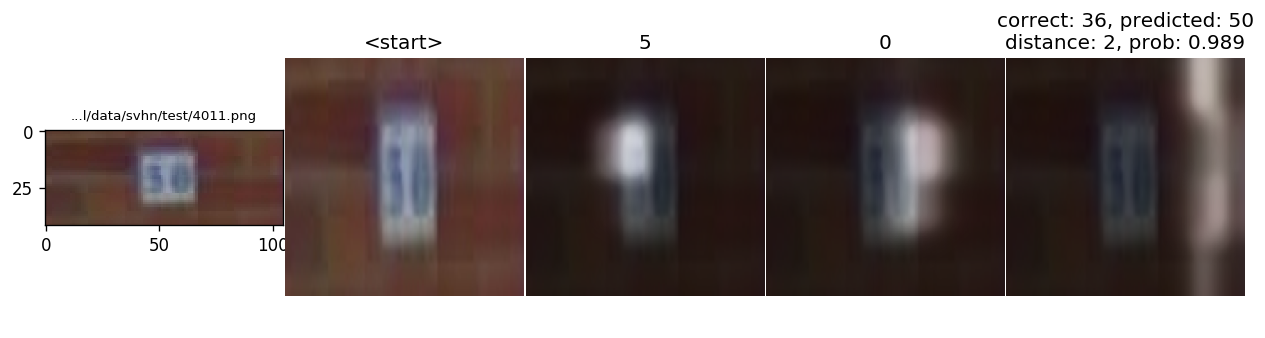

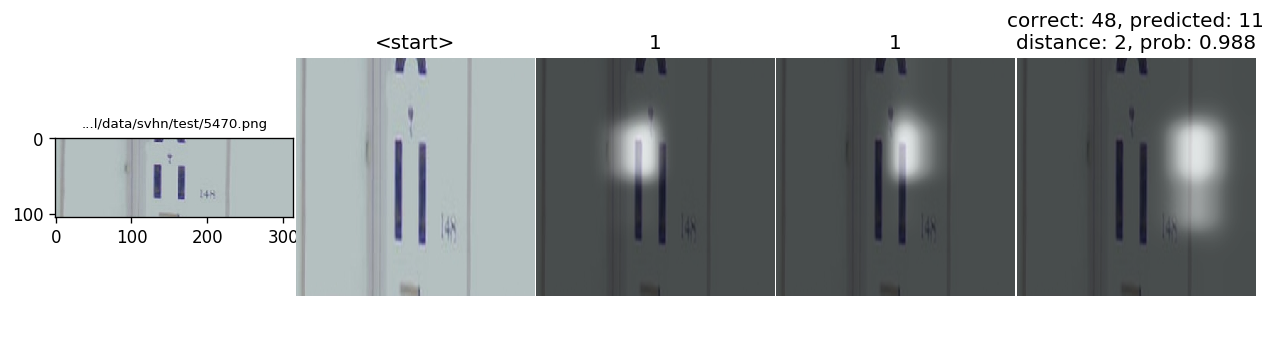

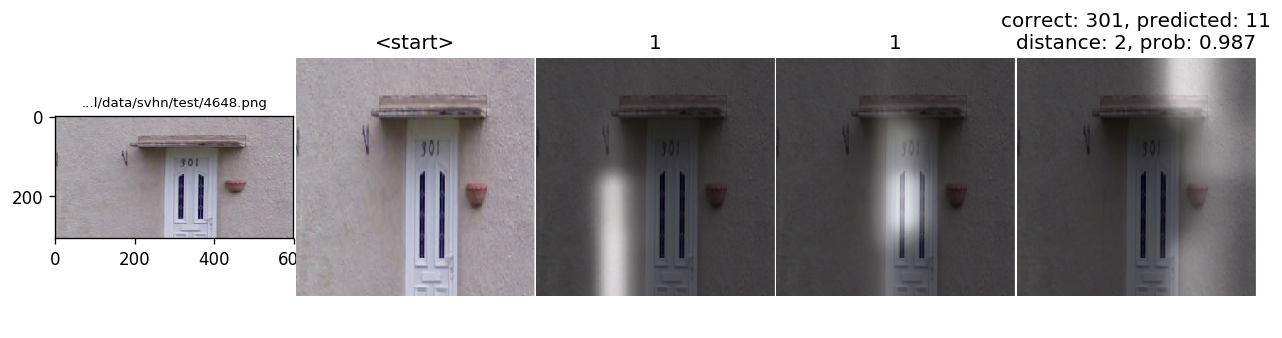

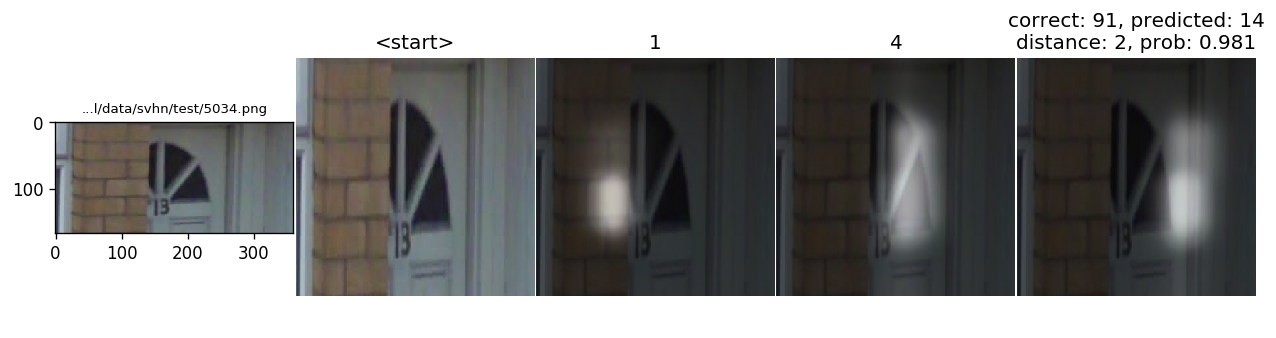

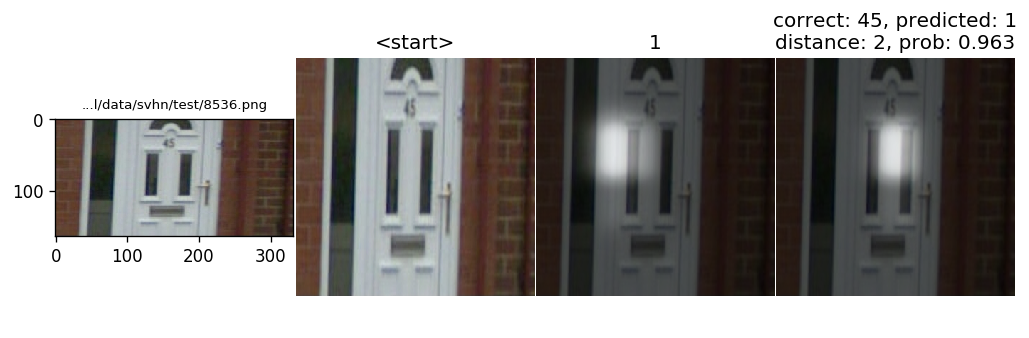

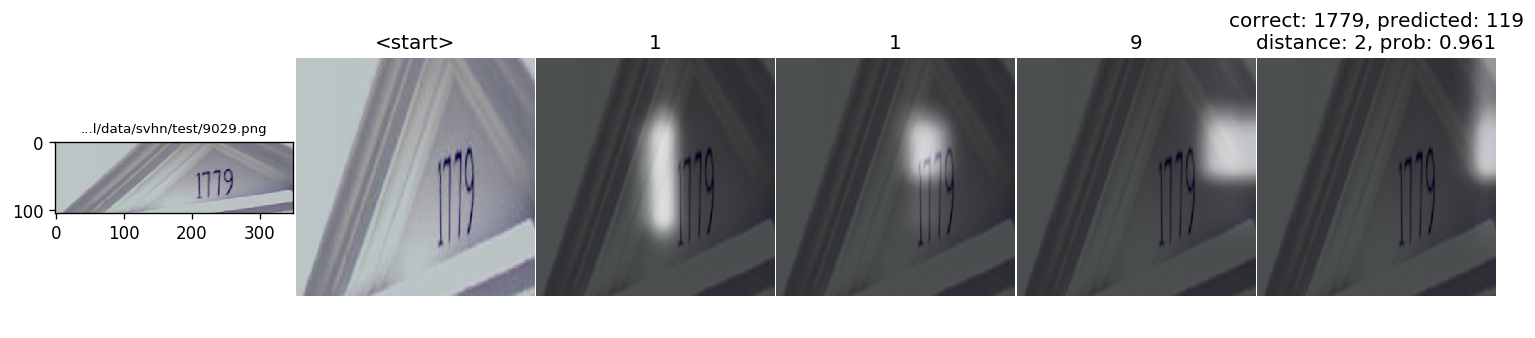

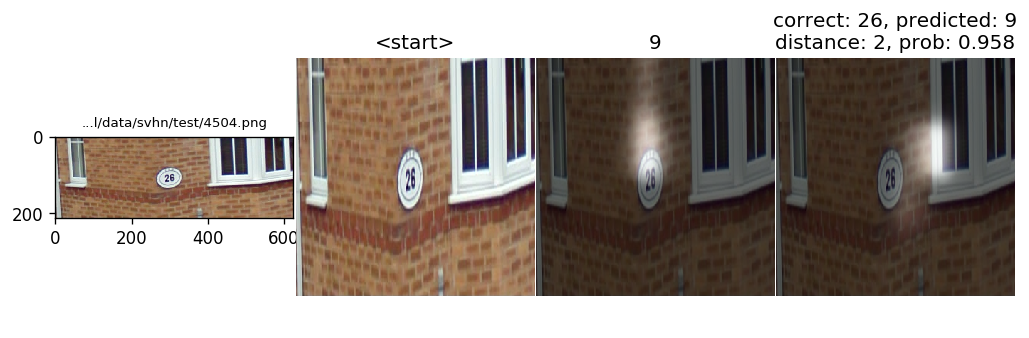

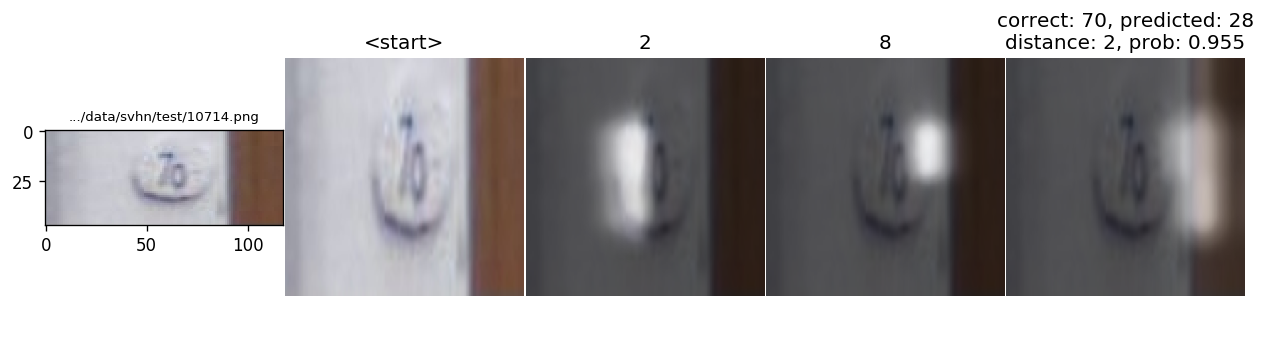

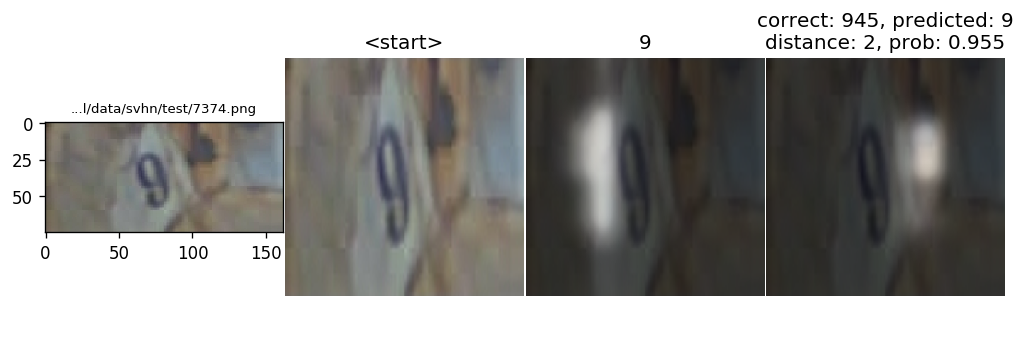

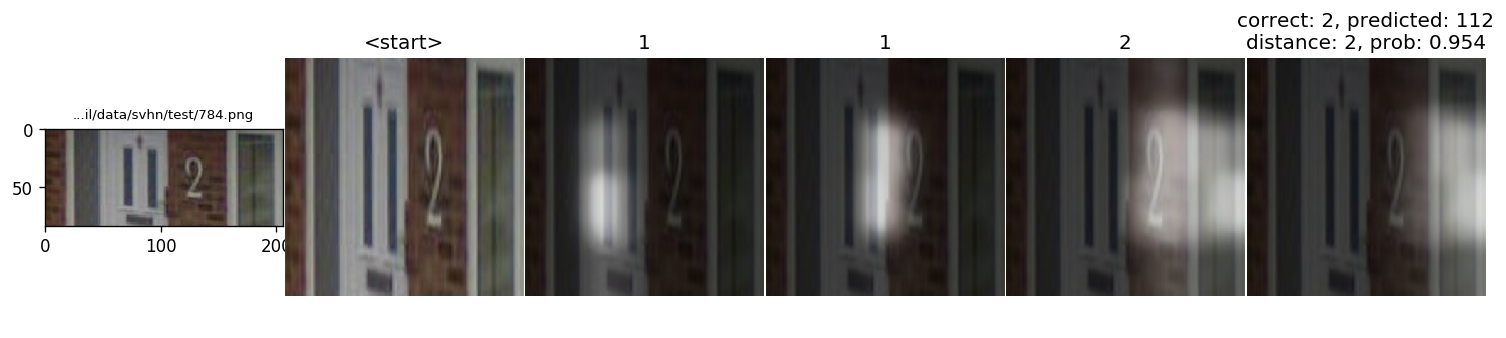

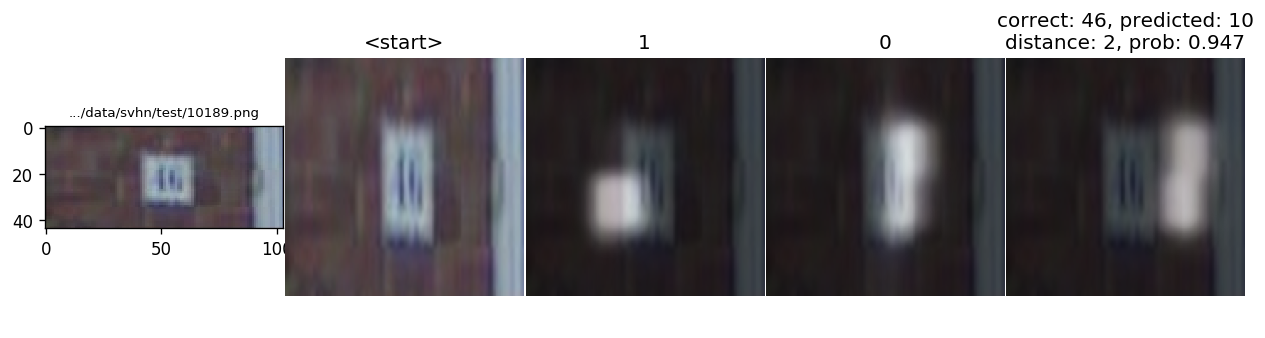

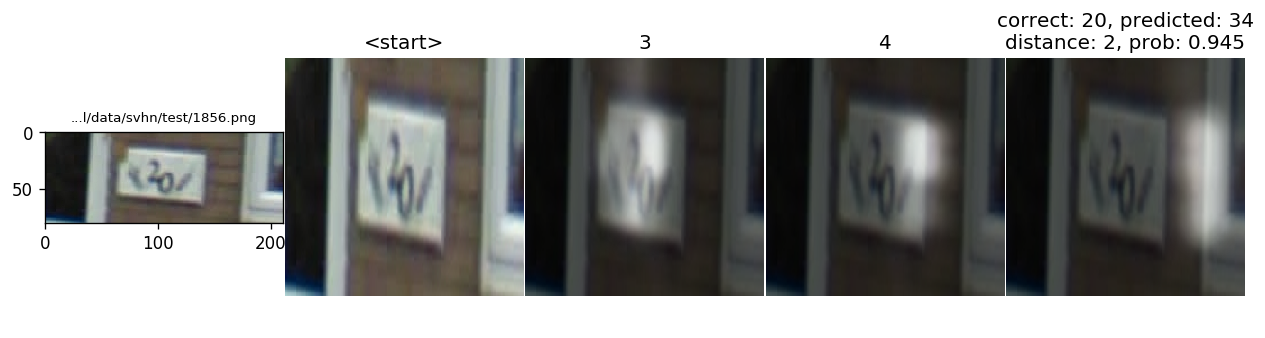

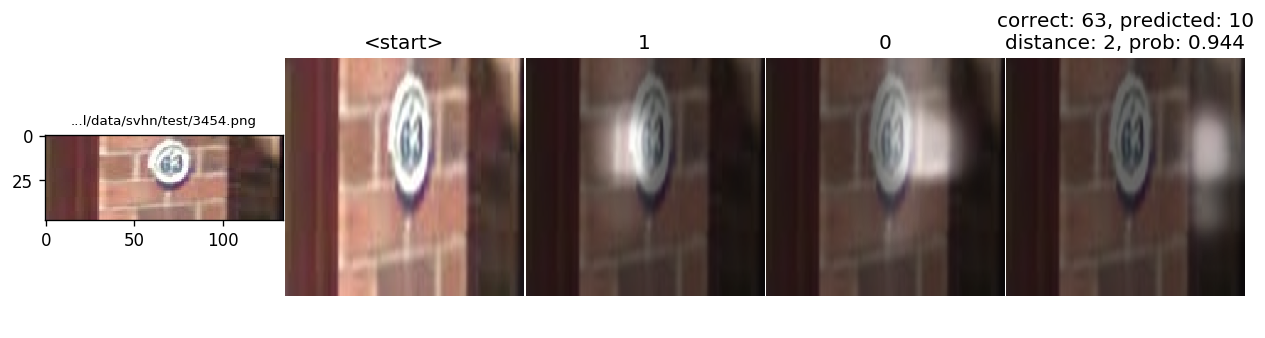

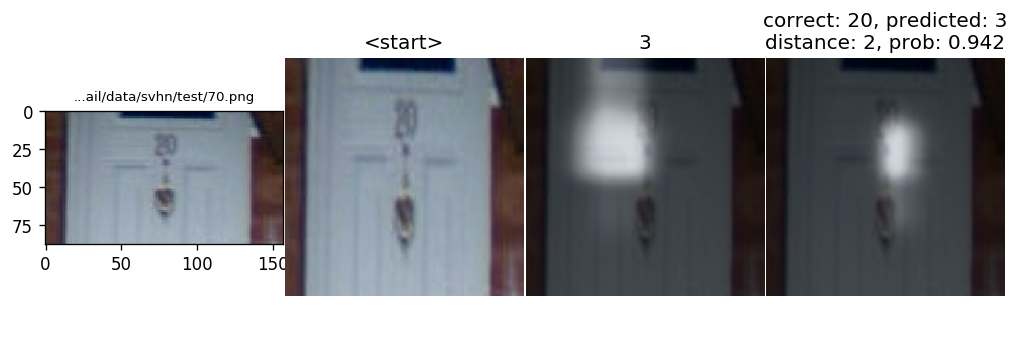

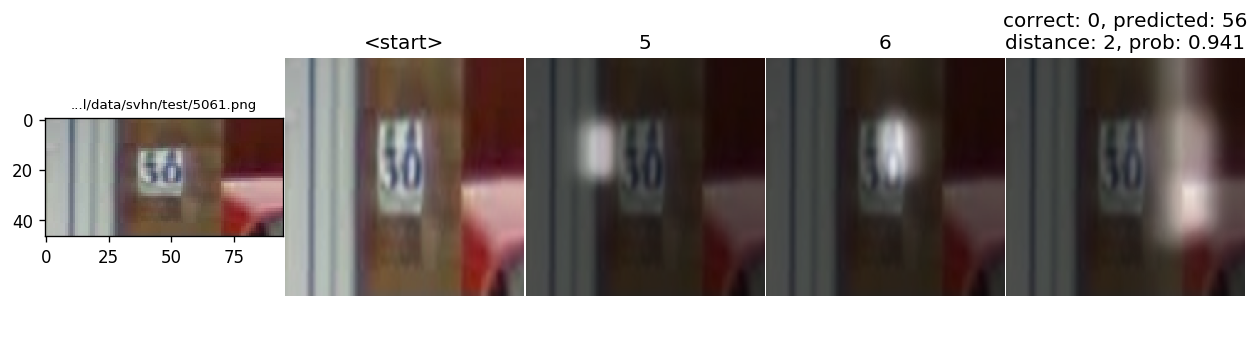

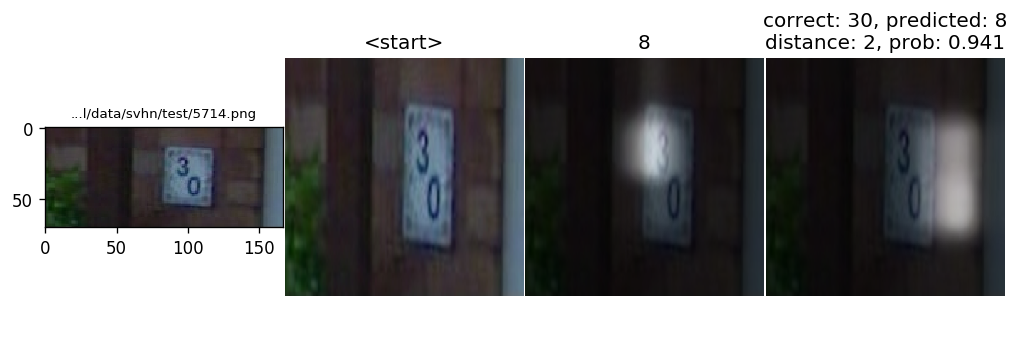

In [9]:
for i, (index, row) in enumerate(report.iterrows()):
    if i > SHOW:
        break
    # Encode, decode with attention and beam search
    seq, alphas = caption_image_beam_search(encoder, decoder, row["path"], word_map, args.beam_size)
    alphas = torch.FloatTensor(alphas)
    # Visualize caption and attention of best sequence
    visualize_att(row["path"], seq, alphas, rev_word_map, args.smooth)
    plt.title("correct: %s, predicted: %s\ndistance: %d, prob: %.3f" % (
        row["correct"], row["predicted"], row["edit_distance"], row["probability"]), fontsize=12)